In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3)

20

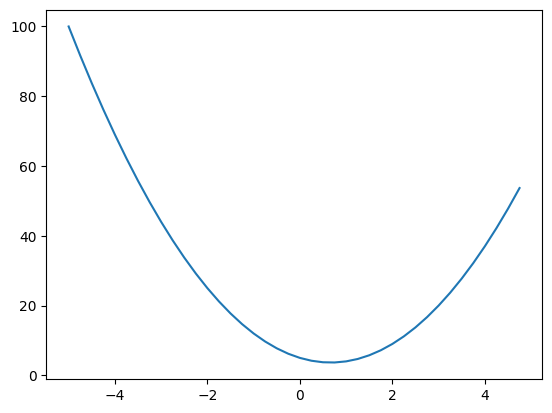

In [4]:
xs = np.arange(-5,5,.25)
ys = f(xs)
plt.plot(xs,ys)

In [5]:
h = 0.0000000000000001
x =3
(f(x+h)- f(x))/h

0.0

In [6]:
a= 2.0
b = -3.0
c = 10.0
d = a*b +c
print(d)

4.0


In [7]:
h = 0.00001

#inputs
a= 2.0
b = -3.0
c = 10.0
d1 = a*b +c
a +=h
d2 = a*b +c

print(f'd1 : {d1}')
print(f'd2 : {d2}')
print(f'slope : {(d2-d1)/h}')

d1 : 4.0
d2 : 3.9999699999999994
slope : -3.000000000064062


In [8]:
h = 0.00001

#inputs
a= 2.0
b = -3.0
c = 10.0
d1 = a*b +c
b +=h
d2 = a*b +c

print(f'd1 : {d1}')
print(f'd2 : {d2}')
print(f'slope : {(d2-d1)/h}')

d1 : 4.0
d2 : 4.00002
slope : 2.0000000000131024


In [9]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{%s |data %.4f | grad %.4f }" % (n.label,n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [21]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        # print(f'type of _children : {type(_children)}')
        self._prev= set(_children)
        self._op = _op
        self.label= label
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        """
            Assumng other either of Value type or number and convert it to Value post typecheck
        """
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data  + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0* out.grad
            other.grad += 1.0* out.grad
        out._backward = _backward
    
        return out
    
    def __neg__(self):
        return self *(-1)
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data *  out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only int and flost are supported"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * self.data **(other -1) * out.grad
        out._backward =_backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self* other**-1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out= Value(t,(self,), 'tanx')
        
        def _backward():
            self.grad += (1- t**2 )* out.grad
        out._backward = _backward 
        return out
    
    def exp(self):
        x = self.data
        t = math.exp(x)
        out= Value(t,(self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward 
        return out

    def backward(self):
        topological_sorted = []
        visited = set()
        def sort_topological_order(v):
            if v not in visited:
                visited.add(v)
                for child  in v._prev:
                    sort_topological_order(child)
                topological_sorted.append(v)
        sort_topological_order(self)
        self.grad = 1.0
        for node in reversed(topological_sorted):
            node._backward()
        

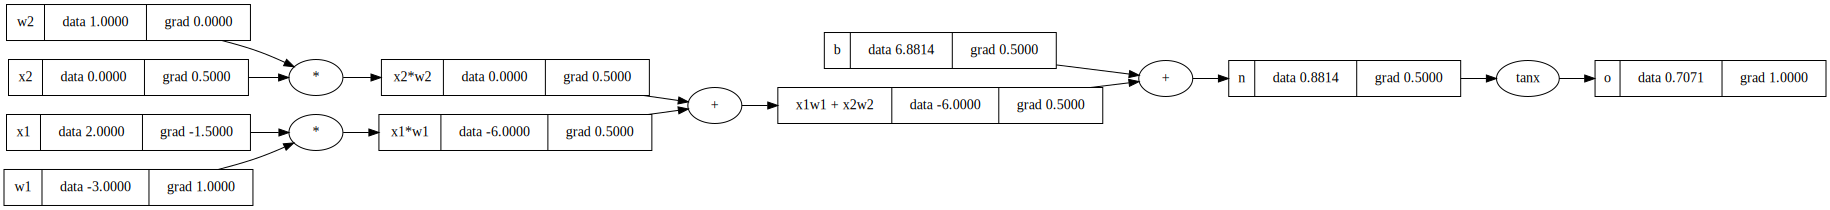

In [31]:
#inputs
x1 = Value(2.0,label='x1')
x2 = Value(0.0, label='x2')
#Weights w1,w2
w1= Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of neuron
b = Value(6.88137, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 +b; n.label = 'n'
o = n.tanh(); o.label='o'
o.backward()
draw_dot(o)

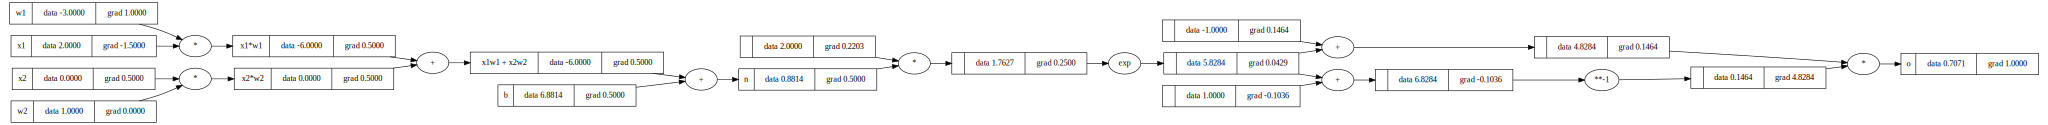

In [23]:
#inputs
x1 = Value(2.0,label='x1')
x2 = Value(0.0, label='x2')
#Weights w1,w2
w1= Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of neuron
b = Value(6.88137, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 +b; n.label = 'n'
e = (2*n).exp()
o= (e-1)/(e+1); o.label='o'
o.backward()
draw_dot(o)


In [ ]:
a = Value(2.0)
2*a

Value(data=4.0)

In [ ]:
# from micrograd.engine import Value

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e+c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
L

Value(data=-8.0)

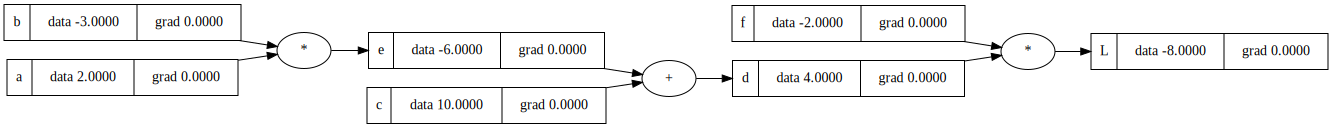

In [ ]:
draw_dot(L)

In [ ]:
def lol():
    h =0.001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; e.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; e.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data +h
    
    print((L2-L1)/h)
lol()

1.000000000000334


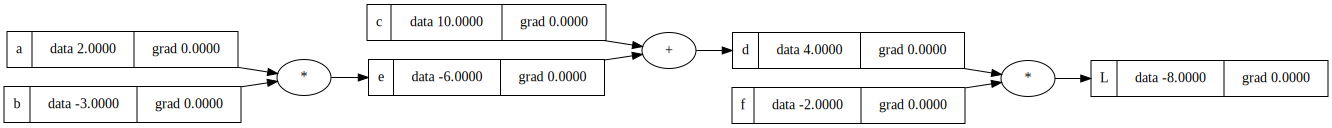

In [ ]:
draw_dot(L)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

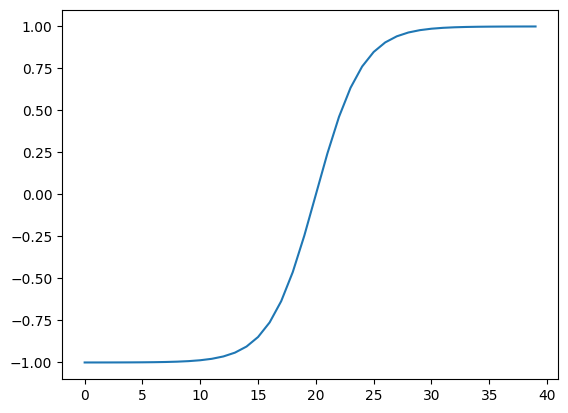

In [ ]:
ar = np.arange(-5,5,.25); tan = np.tanh(ar); plt.plot(tan)

In [ ]:
#inputs
x1 = Value(2.0,label='x1')
x2 = Value(0.0, label='x2')
#Weights w1,w2
w1= Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of neuron
b = Value(6.88137, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 +b; n.label = 'n'
o = n.tanh(); o.label='o'


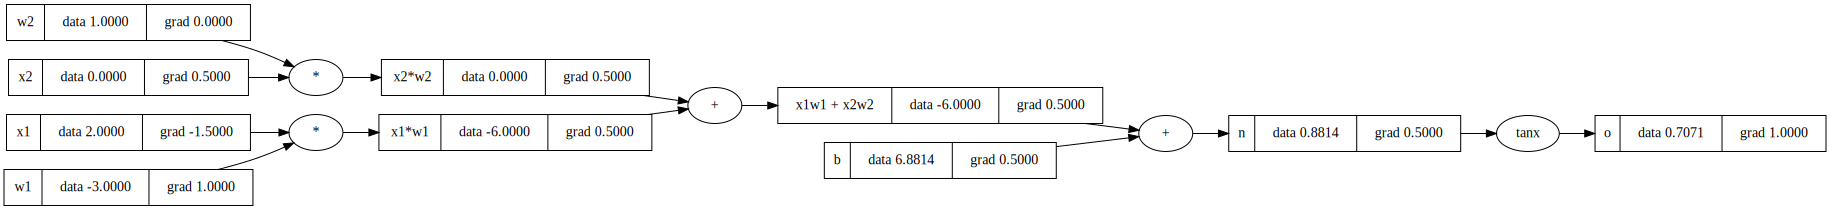

In [ ]:
draw_dot(o)

#filling manula gradient

In [32]:
o.backward()
# o._backward()
# n._backward()
# b._backward()
# x1w1x2w2._backward()
# x1w1._backward()
# x2w2._backward()


# n.grad=0.50000000
# b.grad=0.5
# x1w1x2w2.grad=0.5
# x1w1.grad=0.5
# x2w2.grad=0.5


In [ ]:
a = Value()